In [5]:
# load data from ./data/IXI-DTI/IXI002-Guys-0828-DTI-00.nii.gz

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
# load data
data_path = './data/IXI-DTI/IXI002-Guys-0828-DTI-00.nii.gz'
data = nib.load(data_path).get_fdata()



In [6]:
# Function to add Rician noise
def add_rician_noise(image, noise_std):
    noise1 = np.random.normal(0, noise_std, image.shape)
    noise2 = np.random.normal(0, noise_std, image.shape)
    return np.sqrt((image + noise1) ** 2 + noise2 ** 2)

# Function to calculate noise, SSIM, and PSNR
def calculate_metrics(original, noisy):
    noise = noisy - original
    mean_noise = np.mean(noise)
    std_noise = np.std(noise)
    ssim_value = ssim(original, noisy, data_range=noisy.max() - noisy.min())
    psnr_value = psnr(original, noisy, data_range=noisy.max() - noisy.min())
    return mean_noise, std_noise, ssim_value, psnr_value

In [7]:
print(f"Data min: {data.min()}, max: {data.max()}")
test_noisy_data = data + np.random.normal(0, 0.01, data.shape)
mean_noise, std_noise, ssim_value, psnr_value = calculate_metrics(data, test_noisy_data)
print(f"Test with added noise - Mean Noise: {mean_noise:.4f}, Std Noise: {std_noise:.4f}, SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.4f}")
small_region = data[10:20, 10:20, 10:20]
region_variance = np.var(small_region)
print(f"Variance in small region: {region_variance}")


Data min: 0.0, max: 1758.0
Test with added noise - Mean Noise: -0.0000, Std Noise: 0.0100, SSIM: 1.0000, PSNR: 104.8923
Variance in small region: 0.097959


d:\Anaconda3\envs\mri\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


Original Data Metrics:
Mean Noise: 0.0000, Std Noise: 0.0000, SSIM: 1.0000, PSNR: inf
Metrics after adding Rician Noise:
Mean Noise: 44.8478, Std Noise: 44.4830, SSIM: 0.4045, PSNR: 28.9063


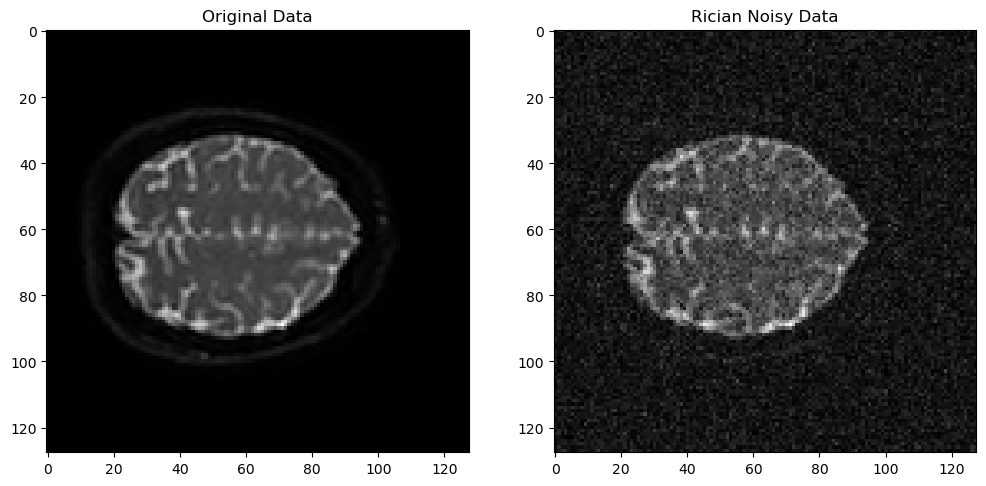

In [8]:
# Original metrics
mean_noise, std_noise, ssim_value, psnr_value = calculate_metrics(data, data)
print(f"Original Data Metrics:")
print(f"Mean Noise: {mean_noise:.4f}, Std Noise: {std_noise:.4f}, SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.4f}")

# Add Rician noise
rician_noisy_data = add_rician_noise(data, noise_std=50)

# Metrics after adding Rician noise
mean_noise, std_noise, ssim_value, psnr_value = calculate_metrics(data, rician_noisy_data)
print(f"Metrics after adding Rician Noise:")
print(f"Mean Noise: {mean_noise:.4f}, Std Noise: {std_noise:.4f}, SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.4f}")

# Visualization
slice_idx = 45
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, slice_idx], cmap='gray')
plt.title('Original Data')
plt.subplot(1, 2, 2)
plt.imshow(rician_noisy_data[:, :, slice_idx], cmap='gray')
plt.title('Rician Noisy Data')
plt.show()

Data Range: [0.0196078431372549, 0.9921568627450981]
Data Range: [0.0, 0.9686274509803922]
Noisy Image PSNR: 19.38dB, SSIM: 0.2358
Denoised Image PSNR: 22.22dB, SSIM: 0.3124


D:\tmpdir\Temp\ipykernel_3708\2924392682.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_val = psnr(img1, img2)


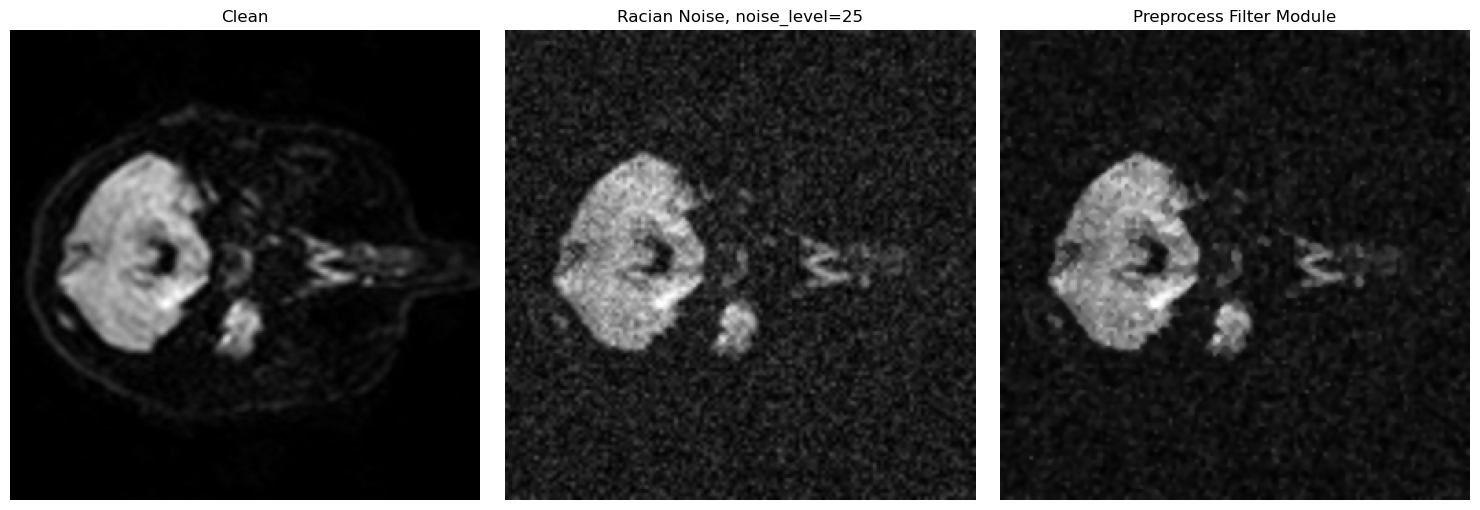

In [9]:
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    normalized_img = img / 255.0
    print(f"Data Range: [{normalized_img.min()}, {normalized_img.max()}]")
    return normalized_img

def calc_metrics(img1, img2):
    psnr_val = psnr(img1, img2)
    ssim_val = ssim(img1, img2, data_range=1.0)
    return psnr_val, ssim_val

def denoise_and_evaluate(noisy_path, clean_path):
    noisy_img = read_img(noisy_path)
    clean_img = read_img(clean_path)
    
    gamma = 1.5
    enhance_img = np.power(noisy_img, gamma)
    
    alpha = 0.4
    enhance_img = (1-alpha) * noisy_img + alpha * enhance_img
    noisy_psnr, noisy_ssim = calc_metrics(clean_img, noisy_img)
    print(f"Noisy Image PSNR: {noisy_psnr:.2f}dB, SSIM: {noisy_ssim:.4f}")
    
    denoised_img = cv2.bilateralFilter(enhance_img.astype(np.float32), d=5, sigmaColor=0.05, sigmaSpace=50)
    
    denoised_psnr, denoised_ssim = calc_metrics(clean_img, denoised_img)
    print(f"Denoised Image PSNR: {denoised_psnr:.2f}dB, SSIM: {denoised_ssim:.4f}")
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(clean_img, cmap='gray')
    plt.title('Clean')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(noisy_img, cmap='gray')
    plt.title('Racian Noise, noise_level=25')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(denoised_img, cmap='gray')
    plt.title('Preprocess Filter Module')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # cv2.imwrite('preprocessed.png', denoised_img * 255)

denoise_and_evaluate('results/se/noisy_6.png', 'results/se/clean_6.png')
